In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score,log_loss
from sklearn.base import clone
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.base import BaseEstimator
import catboost as cat
from tqdm import tqdm
from sklearn import model_selection
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectFromModel

Using TensorFlow backend.


In [2]:
def get_hue_oof(params, X, y, X_test,
                cv_scheme='kf', n_splits=5, shuffle=False, seed=42,
                metrics=None, n_estimators=1000,
                verbose=200, early_stopping_rounds=100,
                conf_matrix=False, conf_matrix_norm=False):
    if metrics is None:
        metrics = [('f1', f1_score)]
    if cv_scheme is 'kf':
        cv_split = model_selection.KFold(n_splits=n_splits, shuffle=shuffle, random_state=seed)
    elif cv_scheme is 'skf':
        cv_split = model_selection.StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=seed)
    else:
        cv_split = model_selection.TimeSeriesSplit(n_splits=n_splits)

    S_train = np.zeros((X.shape[0],))
    S_test = np.zeros((X_test.shape[0],))

    if conf_matrix:
        cms = []
    scores = pd.DataFrame()
    feature_importance = pd.DataFrame()
    for metric_name, metric in metrics:
        scores[metric_name] = np.ndarray((n_splits,))
    columns = X.columns

    for fold_n, (tr_idx, val_idx) in enumerate(cv_split.split(X, y)):
        if type(X) is np.ndarray:
            X_tr, X_val = X[columns][tr_idx], X[columns][val_idx]
            y_tr, y_val = y[tr_idx], y[val_idx]
        else:
            X_tr, X_val = X[columns].iloc[tr_idx], X[columns].iloc[val_idx]
            y_tr, y_val = y[tr_idx], y[val_idx]

        model = lgb.LGBMClassifier(**params,
                                   n_estimators=n_estimators,
                                   n_jobs=-1)
        model.fit(X_tr, y_tr,
                  eval_set=[(X_tr, y_tr), (X_val, y_val)],
                  eval_metric=eval_auc,
                  verbose=verbose,
                  early_stopping_rounds=early_stopping_rounds)

        oof_pred = model.predict_proba(X_val)[:, 1]
        test_pred = model.predict_proba(X_test,
                                        num_iteration=model.best_iteration_)[:, 1]

#         for_metrics = model.predict(X_val)
        for (metric_name, metric) in metrics:
            scores.loc[fold_n, metric_name] = metric(y_val, oof_pred.ravel())

        S_train[val_idx] = oof_pred.ravel()
        S_test += test_pred

        if conf_matrix:
            cms.append(confusion_matrix(y_val, for_metrics))

        fold_importance = pd.DataFrame()
        fold_importance["feature"] = columns
        fold_importance["importance"] = model.feature_importances_
        fold_importance["fold"] = fold_n + 1
        feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    S_test /= n_splits

    feature_importance["importance"] /= n_splits
    cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index
    best_features = feature_importance.loc[feature_importance.feature.isin(cols)]
    plt.figure(figsize=(16, 12))
    sns.barplot(x="importance",
                y="feature",
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LGB Features (avg over folds)')

    if conf_matrix:
        cm = np.average(cms, axis=0)
        plt.figure()
        show_confusion_matrix(cm=cm, classes=[0, 1], normalize=conf_matrix_norm)

    print('=' * 60)
    for metric in scores.columns:
        print(f'[{metric}]\t', 'CV mean:', np.mean(scores[metric]), ', std:', np.std(scores[metric]))
    return S_train.reshape(-1, 1), S_test.reshape(-1, 1)

In [4]:
def reduce_memory_usage(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in tqdm(df.columns):
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (
            start_mem - end_mem) / start_mem))
    
def fast_auc(y_true, y_prob):
    """
    fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
    """
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc


def eval_auc(y_true, y_pred):
    """
    Fast auc eval function for lgb.
    """
    return 'auc', fast_auc(y_true, y_pred), True

def get_df(df_path, dtypes_path):
    path = '../input/ieee-cis-data/'
    df_dtypes = pd.read_csv(path + dtypes_path)
    df_dtypes = df_dtypes.rename(columns={'TransactionID': 'col','int32': 'type'})
    df_dtypes = df_dtypes.to_dict(orient='records')
    new_dtypes = dict()
    for rec in df_dtypes:
        new_dtypes[rec['col']] = rec['type']
    new_dtypes['TransactionID'] = 'int32'

    df = pd.read_csv(path+df_path, dtype=new_dtypes)
    del df_dtypes, new_dtypes
    gc.collect()
    return df

def do_groupby(feat, by,trans=['mean','std']):
    for trans_ in trans:
        train[feat+'_to_'+trans_+'_'+by] = train[feat] / train.groupby([by])[feat].transform(trans_)
        test[feat+'_to_'+trans_+'_'+by] = test[feat] / test.groupby([by])[feat].transform(trans_)

In [5]:
train = get_df('train.csv', 'train_dtypes.csv')
test = get_df('test.csv', 'test_dtypes.csv')
sub = pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv')

In [6]:
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]
many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.9]
big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
skewed_cols = [col for col in train.columns if train[col].value_counts(normalize=True).values[0] > 0.95]
skewed_cols_test = [col for col in test.columns if test[col].value_counts(normalize=True).values[0] > 0.95]
cols_to_drop = list(set(many_null_cols + many_null_cols_test + big_top_value_cols + skewed_cols + skewed_cols_test+
                        big_top_value_cols_test + one_value_cols+ one_value_cols_test))
cols_to_drop.remove('isFraud')

train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)
gc.collect()

14

In [7]:
train[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = train['P_emaildomain'].str.split('.', expand=True)
train[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = train['R_emaildomain'].str.split('.', expand=True)

test[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = test['P_emaildomain'].str.split('.', expand=True)
test[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = test['R_emaildomain'].str.split('.', expand=True)
gc.collect()

40

In [8]:
train.loc[
    train.DeviceInfo.isin(
        train.DeviceInfo.value_counts()[train.DeviceInfo.value_counts() < 50].index), 
    'DeviceInfo'] = "Others"

In [9]:
train = train.drop(['P_emaildomain_3', 'R_emaildomain_3','P_emaildomain','R_emaildomain'], axis=1)
test = test.drop(['P_emaildomain_3', 'R_emaildomain_3','P_emaildomain','R_emaildomain'], axis=1)
gc.collect()

28

In [10]:
do_groupby('TransactionAmt','card1',['mean'])
do_groupby('TransactionAmt','card3',['mean'])
do_groupby('TransactionAmt','card5',['mean'])
do_groupby('TransactionAmt','card2',['mean','std'])
do_groupby('TransactionAmt','card4',['mean','std'])
# do_groupby('TransactionAmt','dist1',['mean'])
do_groupby('TransactionAmt','ProductCD',['mean','std'])
do_groupby('TransactionAmt','addr1',['mean'])
# do_groupby('TransactionAmt','DeviceInfo',['mean','std'])
do_groupby('TransactionAmt','P_emaildomain_1',['mean','std'])
do_groupby('TransactionAmt','R_emaildomain_1',['mean','std'])

do_groupby('D15','card1',['mean'])
do_groupby('D15','card3',['mean'])
do_groupby('D15','card5',['mean'])
do_groupby('D15','card2',['mean','std'])
do_groupby('D15','card4',['mean','std'])
# do_groupby('D15','dist1',['mean'])
# do_groupby('D15','ProductCD',['mean','std'])
# do_groupby('D15','addr1',['mean'])

# do_groupby('Weekday','TransactionAmt',['mean','std'])
# do_groupby('Hour','TransactionAmt',['mean','std'])
# do_groupby('Day','TransactionAmt',['mean','std'])

In [11]:
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']
X_test = test.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)
del train
test = test[["TransactionDT", 'TransactionID']]
gc.collect()

71

In [12]:
X = X[chosen_cols]
X_test = X_test[chosen_cols]

In [13]:
obj_cols_X = list(X.select_dtypes(include=['object']).columns)
obj_cols_X_test = list(X_test.select_dtypes(include=['object']).columns)
obj_cols_X == obj_cols_X_test

True

In [14]:
for col in obj_cols_X:
    le = LabelEncoder()
    le.fit(list(X[col].astype(str).values) + list(X_test[col].astype(str).values))
    X[col] = le.transform(list(X[col].astype(str).values))
    X_test[col] = le.transform(list(X_test[col].astype(str).values))  
X_test = X_test.fillna(-999)
X = X.fillna(-999)

In [15]:
lgb_params = {
    "boosting_type": "gbdt",
    'objective': 'binary',
    "metric": 'auc',
    'max_depth': 7,
    'num_leaves': 50,
    'learning_rate': 0.03,
    'min_child_samples': 70,
    
    "subsample_freq": 3,
    "subsample": 0.9,
    "bagging_seed": 24,
    "verbosity": -1,
    'reg_alpha': 0.3,
    'reg_lambda': 0.3,
    'colsample_bytree': 0.9,
}

model = lgb.LGBMClassifier(**lgb_params, n_estimators=1000, n_jobs = -1)

In [16]:
rus = RandomUnderSampler(random_state=42, sampling_strategy='majority')
X_rus,y_rus = rus.fit_sample(X, y)
X_rus = pd.DataFrame(X_rus, columns=X.columns)

In [17]:
embeded_lgb_selector = SelectFromModel(model, threshold='1.25*median')
embeded_lgb_selector.fit(X_rus, y_rus)
embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X_rus.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

63 selected features


In [18]:
del X_rus, y_rus
gc.collect()

47

In [20]:
X_ros = X_ros[embeded_lgb_feature]
X_test = X_test[embeded_lgb_feature]

NameError: name 'X_ros' is not defined

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.91251	training's auc: 0.91251	valid_1's auc: 0.895005	valid_1's auc: 0.895005
[200]	training's auc: 0.933155	training's auc: 0.933155	valid_1's auc: 0.909334	valid_1's auc: 0.909334
[300]	training's auc: 0.946316	training's auc: 0.946316	valid_1's auc: 0.918118	valid_1's auc: 0.918118
[400]	training's auc: 0.956005	training's auc: 0.956005	valid_1's auc: 0.924114	valid_1's auc: 0.924114
[500]	training's auc: 0.963292	training's auc: 0.963292	valid_1's auc: 0.928175	valid_1's auc: 0.928175
[600]	training's auc: 0.969354	training's auc: 0.969354	valid_1's auc: 0.931766	valid_1's auc: 0.931766
[700]	training's auc: 0.974829	training's auc: 0.974829	valid_1's auc: 0.934621	valid_1's auc: 0.934621
[800]	training's auc: 0.979232	training's auc: 0.979232	valid_1's auc: 0.936916	valid_1's auc: 0.936916
[900]	training's auc: 0.983134	training's auc: 0.983134	valid_1's auc: 0.939212	valid_1's auc: 0.939212
[10

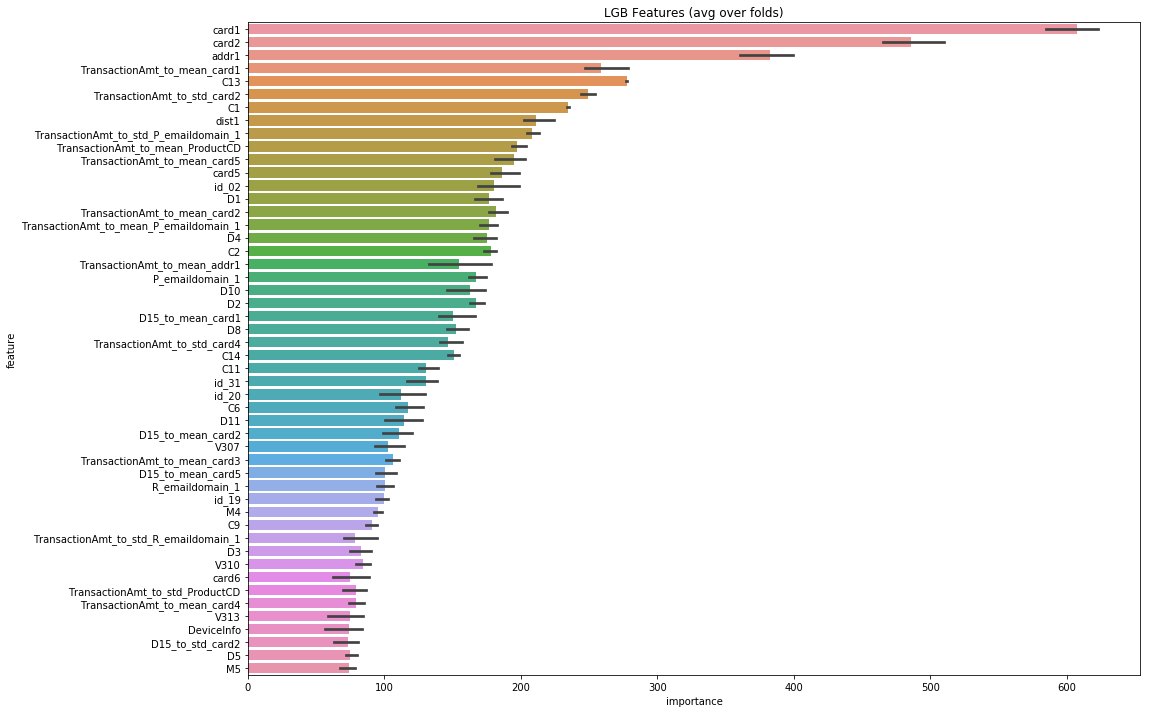

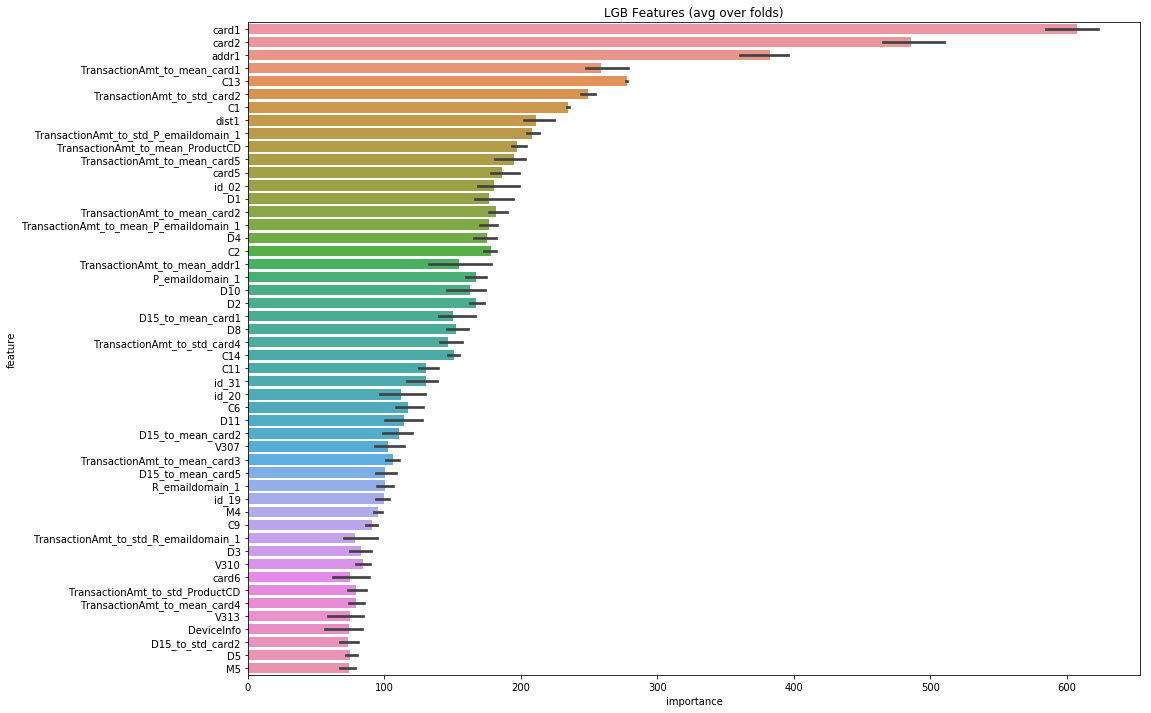

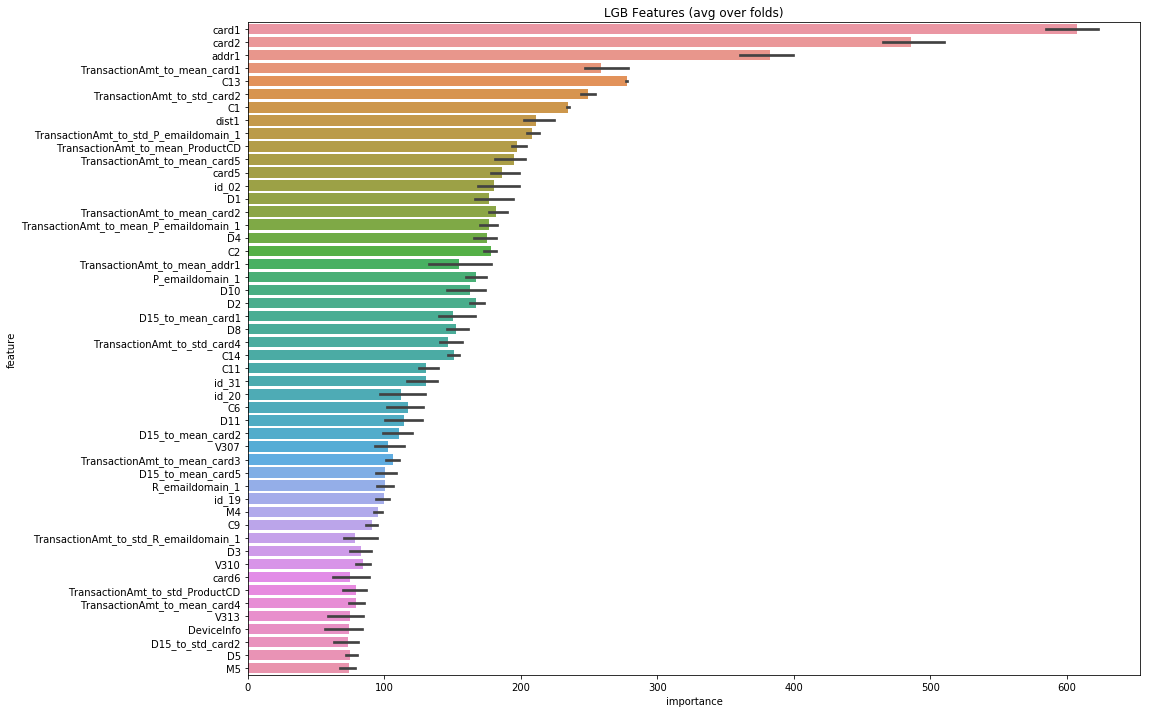

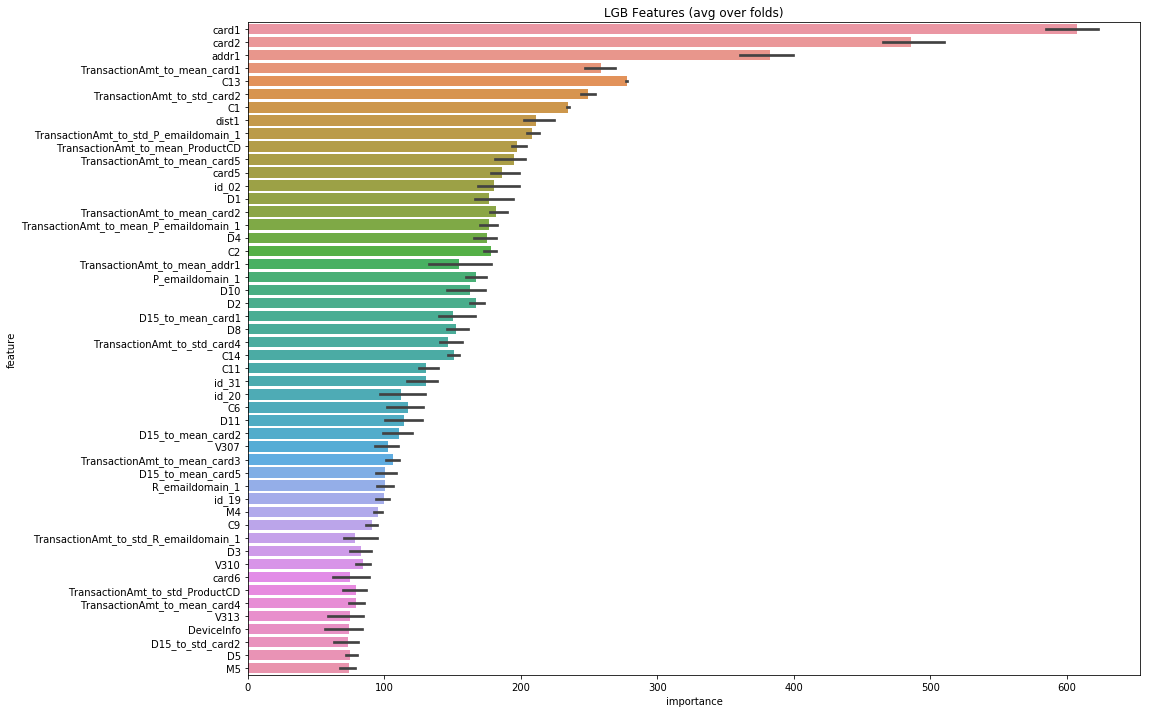

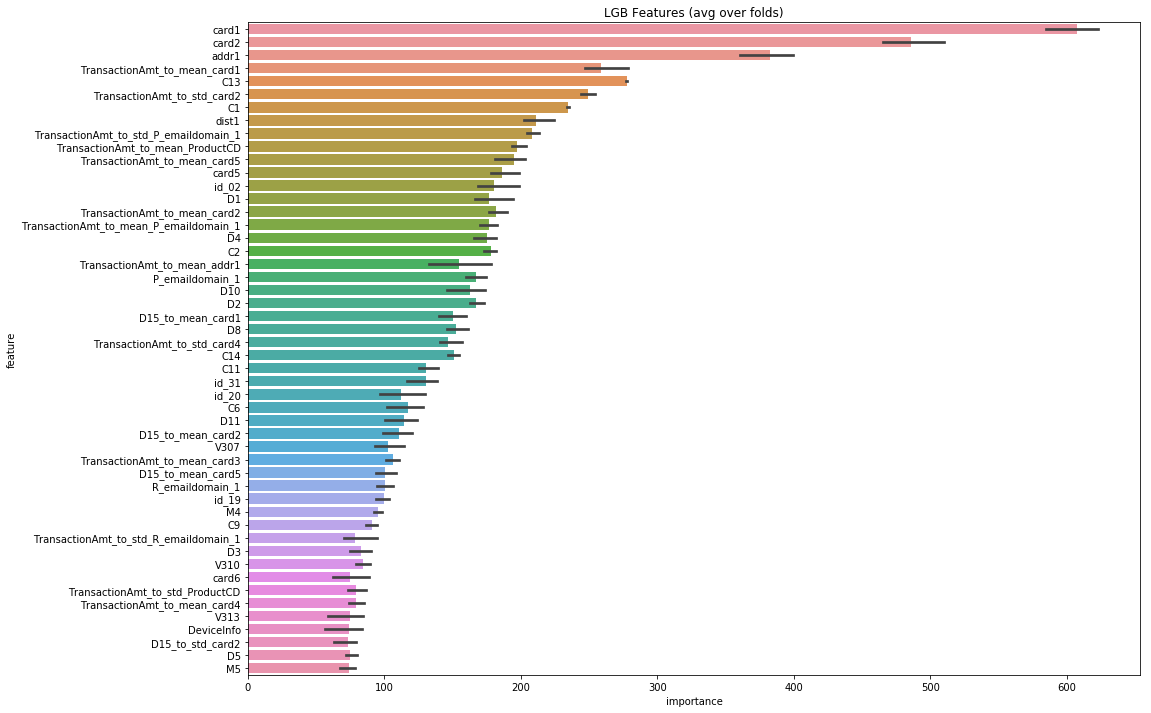

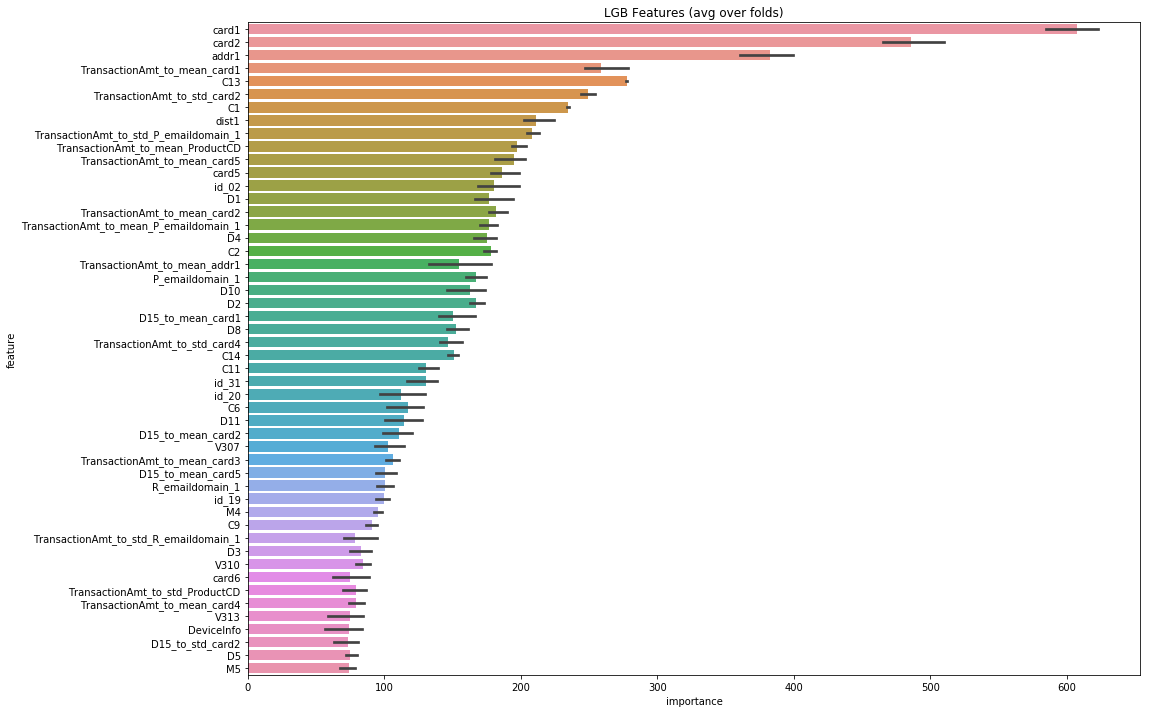

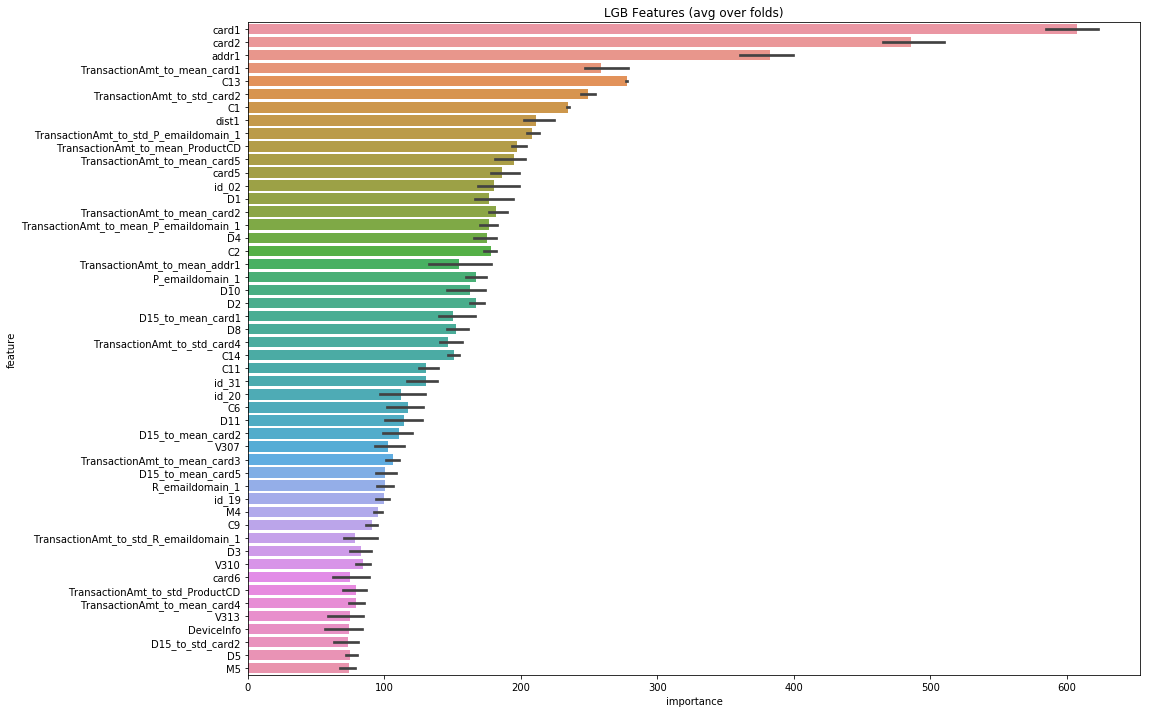

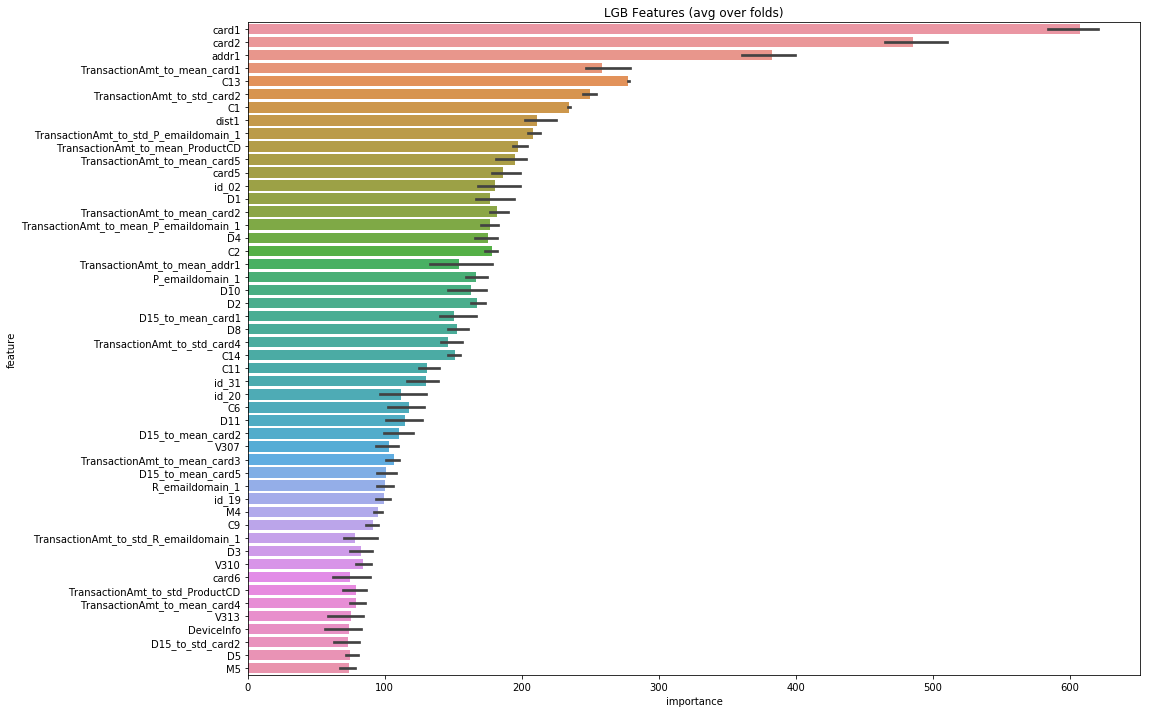

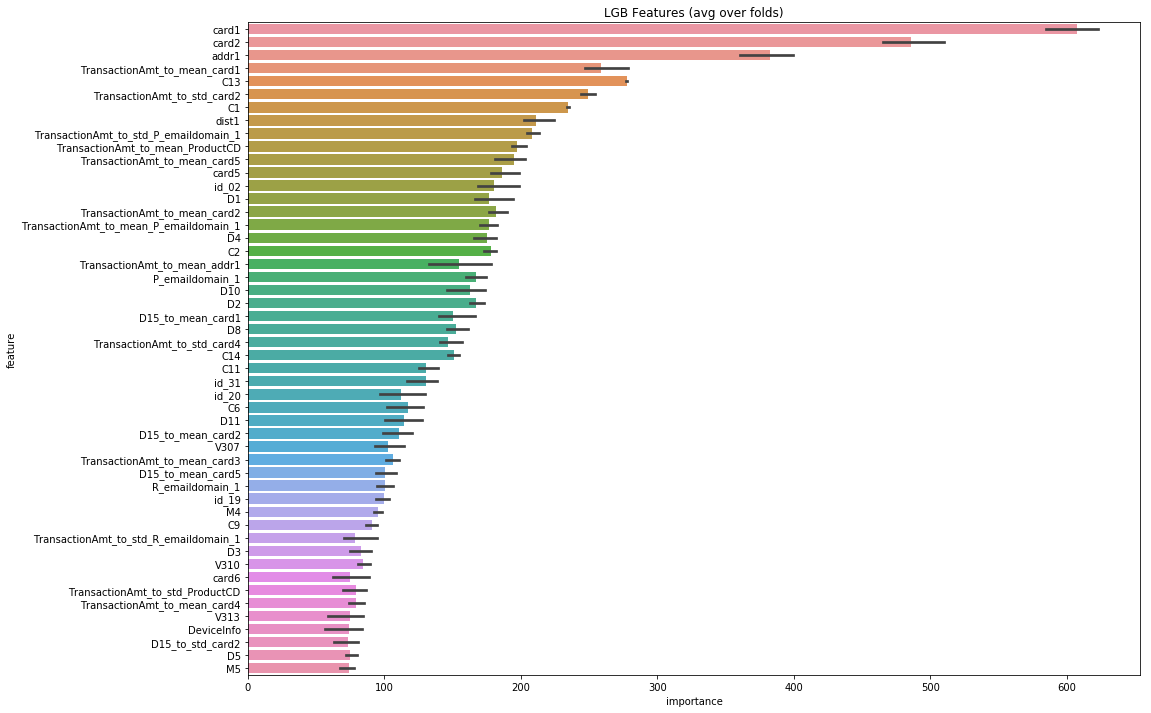

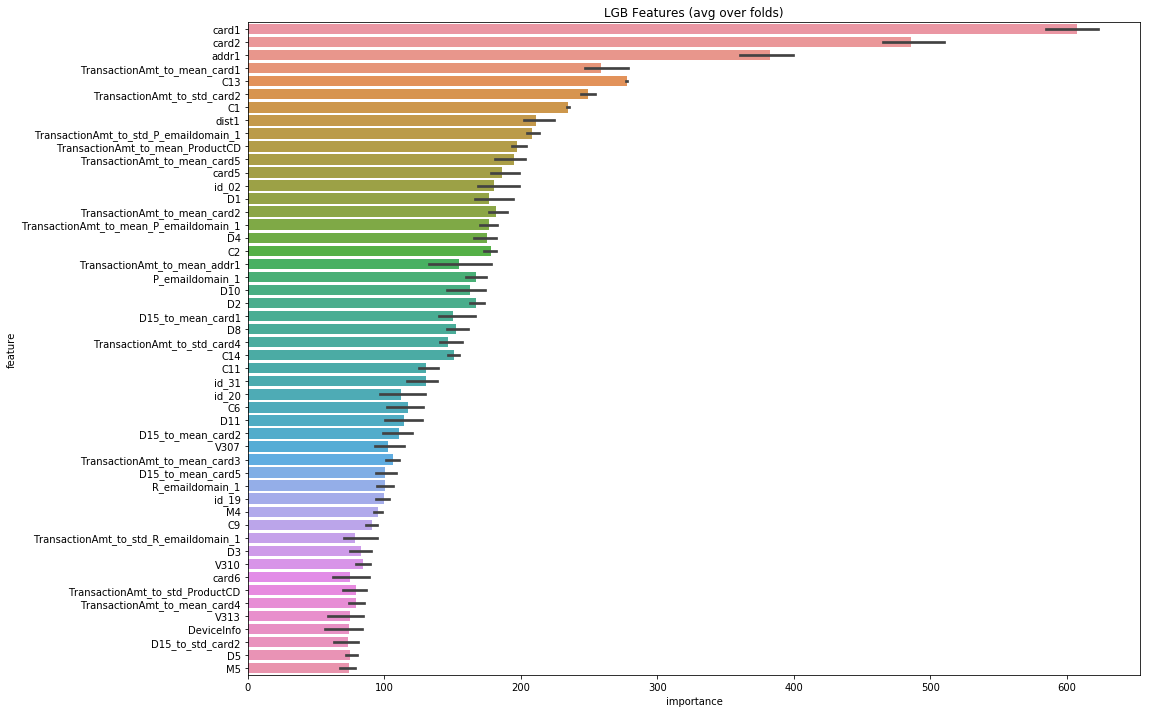

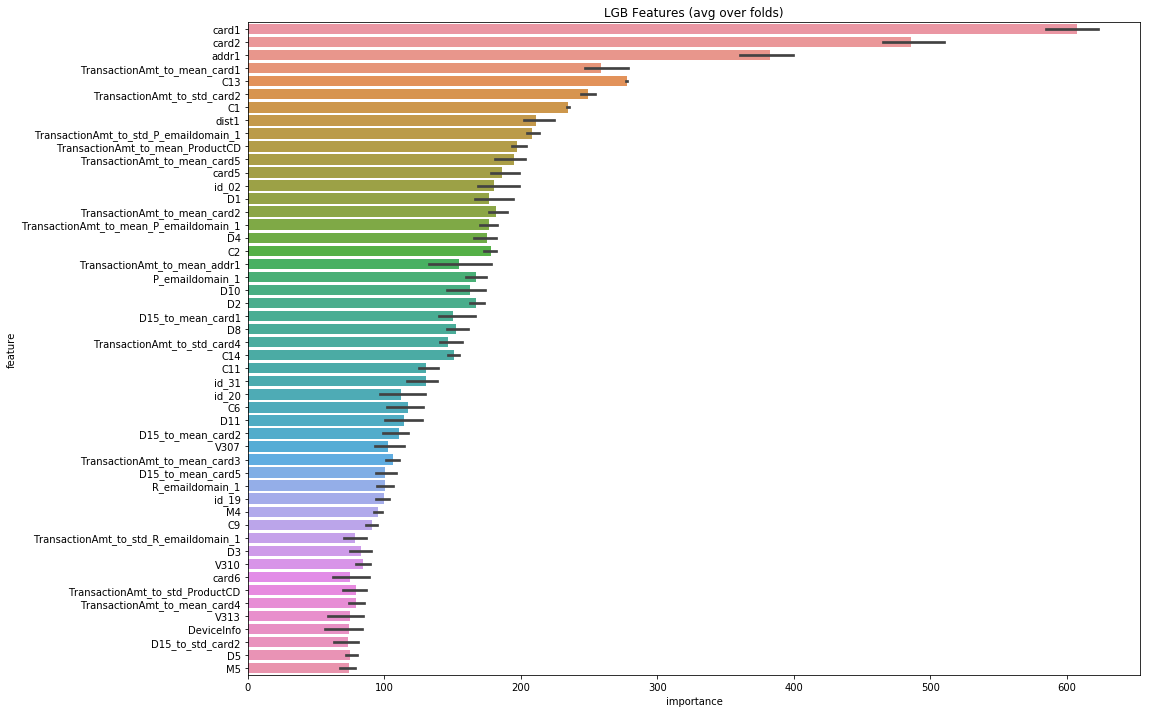

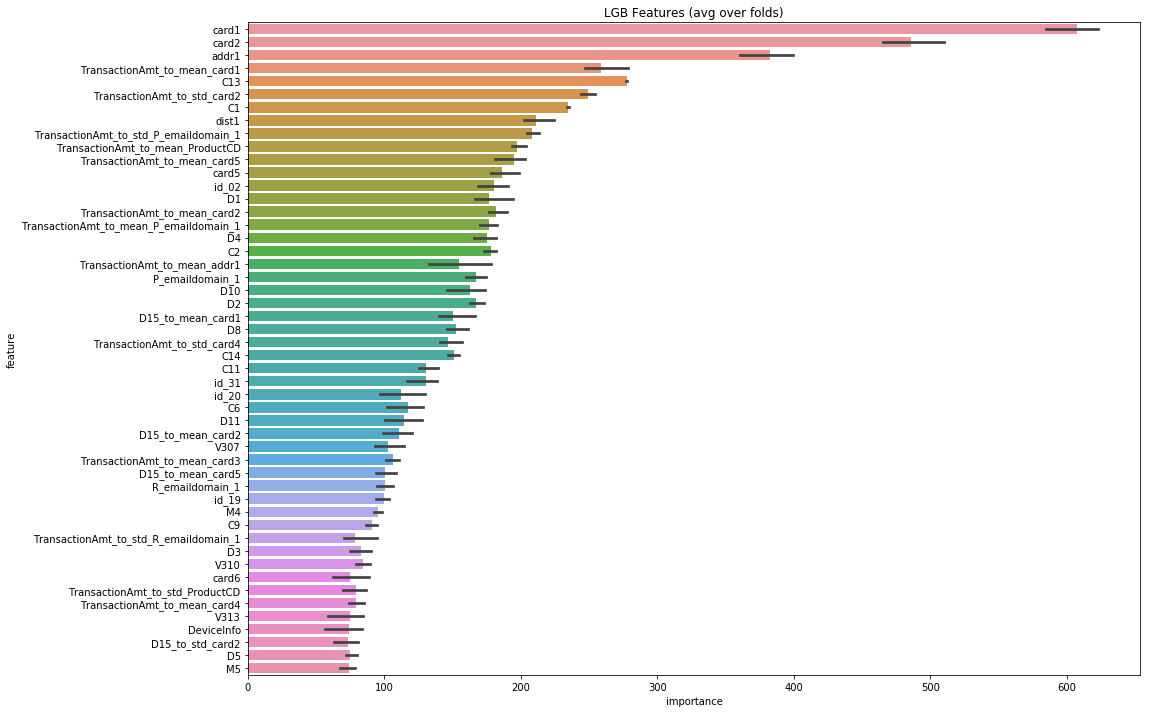

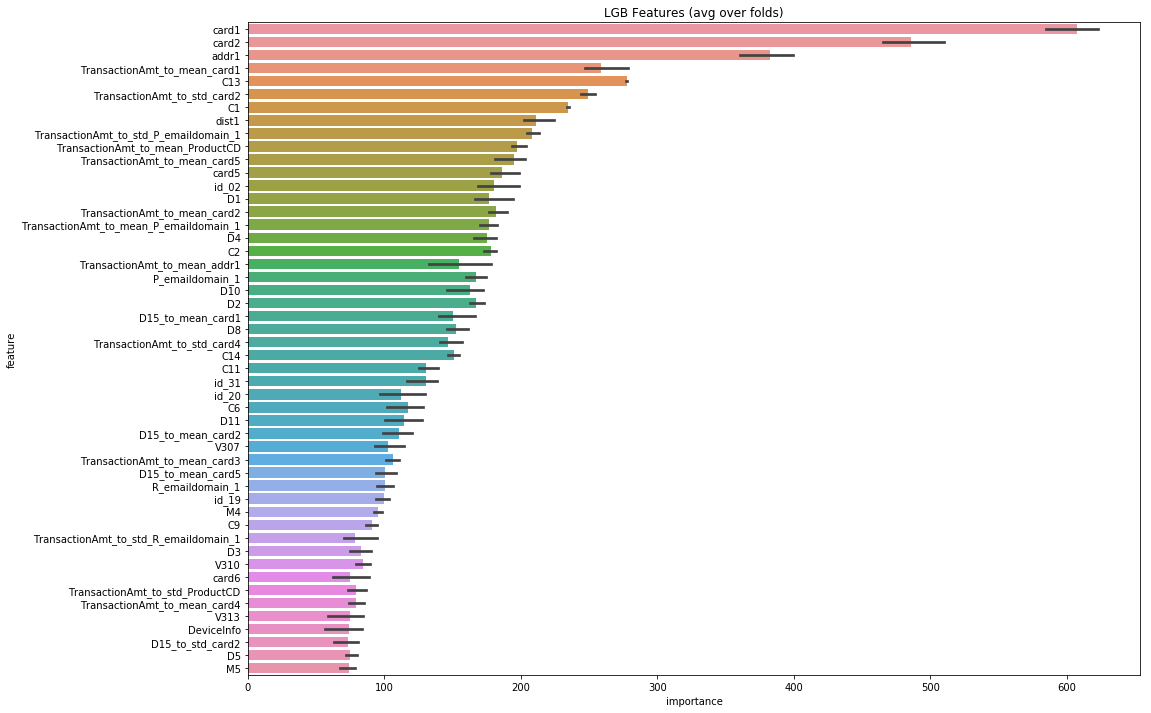

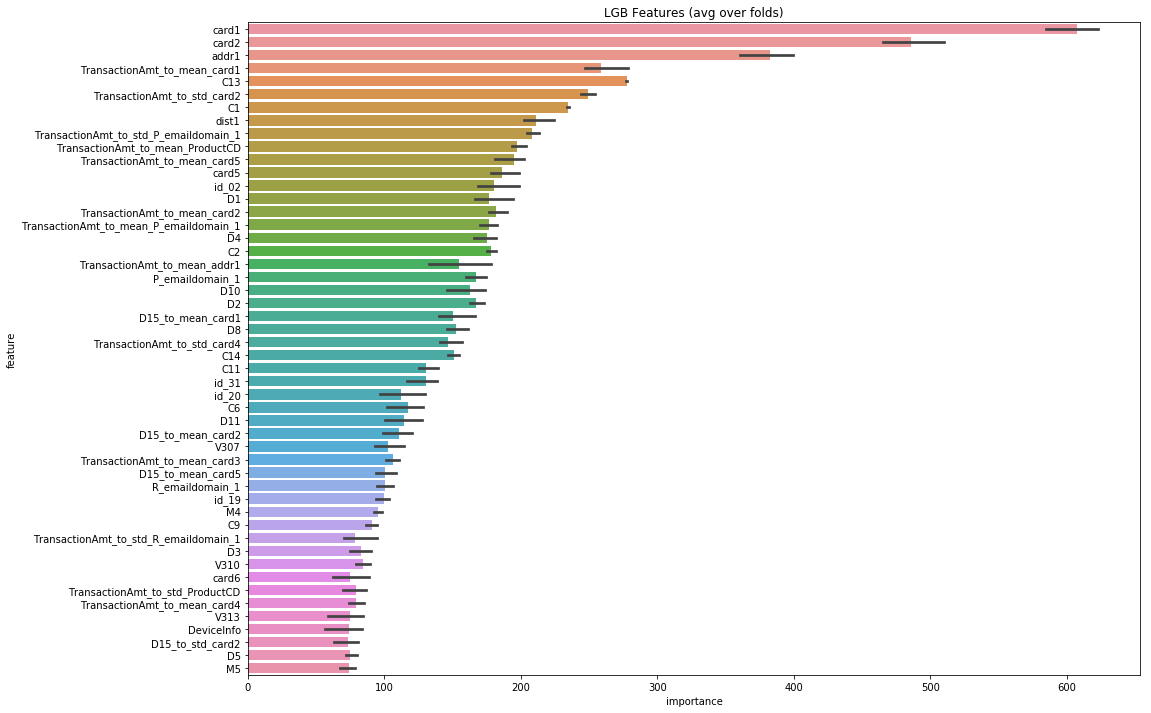

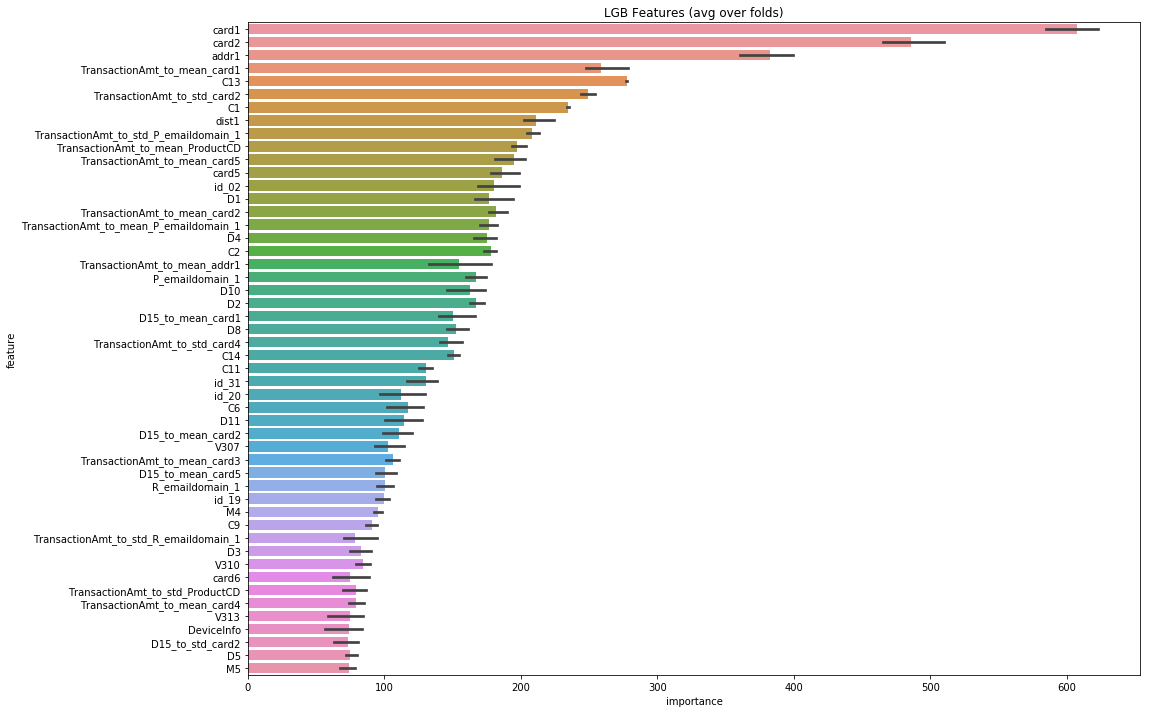

In [21]:
metrics =[
    ('log_loss', log_loss),
]

ITERS = 15
pred = np.zeros((X_test.shape[0],ITERS))
for i in range(ITERS):
    ros = RandomUnderSampler(random_state=42, sampling_strategy='majority')
    X_rus,y_rus = ros.fit_sample(X, y)
    X_rus = pd.DataFrame(X_rus, columns=X.columns)
     
    oof_lgb, pred_lgb = get_hue_oof(lgb_params, X=X_rus, y=y_rus, X_test=X_test,
                    cv_scheme='kf', n_splits=3, shuffle=True, seed=42,
                    metrics=metrics,n_estimators=1000,verbose=100)
    
    del X_rus,y_rus
    gc.collect()
    pred[:, i] = pred_lgb.ravel()

In [22]:
test = test.sort_values('TransactionDT')
test['prediction'] = pred.mean(axis=1)
sub['isFraud'] = pd.merge(sub, test, on='TransactionID')['prediction']
sub.to_csv('rus.csv', index=False)